# **STUDENT AI** - MATH MODEL CREATION (CLASSIFICATION)

## Objectives

Create a classification model to predict Math score based on Key dataset features. Numerical variables will be grouped into bins. <br> 
Initially I will try to use 5, analog to the EDA study grouping student performance based on the mean value and 1-2 standard deviations from mean. That would allow the model to predict students in the fail, below average, average, above average and exeptional categories. - however accuracy is still a concearn, so alternative classification will be analysed using 3 bins. This will allow prediction of below average, average and above average performance and will probably achieve higher accuracy in prediction. <br>
Worst case, the dataset would have to be grouped into 2 bins around the mean allowing classification into below average and above average.

This would flag many more students however of needing additional assistance. 

## Inputs

Continues to assess dataset loaded in previous notebook.

## Outputs

Pipeline and .pkl file to use for predicting a students math score based on the derived calculated best feature variables.


---

# Import required libraries

In [2]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

### Pipeline
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### libraries for custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

### Feature Balancing
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

### Feature  Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

### EqualFrequencyDiscretiser
from feature_engine.discretisation import EqualFrequencyDiscretiser

### packages for classification report and confusion matrix
from sklearn.metrics import make_scorer, recall_score

### Train test split
from sklearn.model_selection import train_test_split

### Packages for generating a classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

### GridSearchCV
from sklearn.model_selection import GridSearchCV

print('All Libraries Loaded')

All Libraries Loaded


# Change working directory

### Set the working directory to notebook parent folder
If the output does not match, click **'clear all outputs'** and then **'restart'** the notebook. 
Then run cells from top to bottom.

In [6]:
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print('If correct, Active Directory should read: /workspace/student-AI')
print(f"Active Directory: {current_dir}")

If correct, Active Directory should read: /workspace/student-AI
Active Directory: /workspace/student-AI


### Load cleaned dataset

In [7]:
df = pd.read_csv(f"outputs/dataset/Expanded_data_with_more_features_clean.csv")
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,female,group C,bachelor's degree,standard,none,married,regularly,yes,3,< 5,71,71,74
1,female,group C,some college,standard,none,married,sometimes,yes,0,5 - 10,69,90,88
2,female,group B,master's degree,standard,none,single,sometimes,yes,4,< 5,87,93,91
3,male,group A,associate's degree,free/reduced,none,married,never,no,1,5 - 10,45,56,42
4,male,group C,some college,standard,none,married,sometimes,yes,0,5 - 10,76,78,75


In [81]:
# df['NrSiblings'] = df['NrSiblings'].astype(str)
df_math = df.drop(['ReadingScore', 'WritingScore','ParentMaritalStatus',
                'PracticeSport',
                'IsFirstChild',
                'NrSiblings',
                'WklyStudyHours'], axis=1)
df_math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Gender       30641 non-null  object
 1   EthnicGroup  30641 non-null  object
 2   ParentEduc   30641 non-null  object
 3   LunchType    30641 non-null  object
 4   TestPrep     30641 non-null  object
 5   MathScore    30641 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 1.4+ MB


## Build Pipeline for classification model to predict Math numerical target variable

The steps for a classification model are a little more involved when using a dataset with a numerical target variable

| Step |  Purpose | 
|---|---|
|Data Cleaning|Deal with missing data or wrong data - step already completed in the saved dataset|
|Discretize Numerical Target|group tagerget variable into bins for categorization|
|Encode Categorical Features|Model algorithms can only handle numerical data. Needs to be converted first|
|Feature Scaling|Ensure all numerical data has a similar scale and is centered around zero - neccessary / improves model performance|
|Data Balancing|Classification models are affected negatively by imbalanced data. SMOTE or Undersampling needs to be performed to balance the dataset|
|Feature Smart Correlation|Determine which features are most significant and eliminate uneccessary ones - helps prevent overfitting - not neccesary|
|Feature Selection|Select which features will be used |
|Algorithm Selection|Assess best algorithm for the data set as well as the best associated Parameters and Hyperparameters|
|Model Training|Train the model on the train data and evaluate with the test set|

### To select the best algorithm and hyperparameters we will fit a model with each different type / parameter set and compare the results.
To do this I can use the custom parameter test function, derived in the CodeInstitute Churnometer Walkthrough [here](https://github.com/AdamBoley/churnometer/blob/main/jupyter_notebooks/06%20-%20Modeling%20and%20Evaluation%20-%20Predict%20Tenure.ipynb)

### Prepare Pipeline steps:

In [82]:
def PipelineOptimization(model):
    pipeline_base = ImbPipeline([

        # ("custom_discretizer", CustomDiscretizer(n_bins=5, columns=['MathScore'])),

        ("OrdinalCategoricalEncoder", OrdinalEncoder(
            encoding_method='arbitrary', 
            variables=[
                'Gender',
                'EthnicGroup',
                'ParentEduc',
                'LunchType',
                'TestPrep',
                ])),

        # ("undersample", RandomUnderSampler()),  # Assuming enough data values - another option will be SMOTE

        ("feature_selection", SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

In [83]:
models_algorithm_list = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

parameters_list = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

### Custom Confusion Matrix Function from CI Customer Churn Course

In [84]:
def confusion_matrix_and_report(x, y, pipeline, label_map):

  prediction = pipeline.predict(x)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")

  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=label_map),"\n")

def clf_performance(math_train_features, math_train_scores, math_test_features, math_test_scores, pipeline, label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(math_train_features, math_train_scores, pipeline, label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(math_test_featuress, math_test_scores, pipeline, label_map)

### Custom Hyperparameter search class (same as previous notebook)

In [85]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, parameters):
        self.models = models
        self.parameters = parameters
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, x, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model =  PipelineOptimization(self.models[key])

            parameters = self.parameters[key]
            grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            grid_search.fit(x, y)
            self.grid_searches[key] = grid_search

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, parameters):
            summary = {
                 'estimator': key,
                 'minimum_score': min(scores),
                 'maximum_score': max(scores),
                 'mean_score': np.mean(scores),
                 'standard_deviation_score': np.std(scores),
            }
            return pd.Series({**parameters,**summary})

        rows = []
        for k in self.grid_searches:
            parameters = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                result = self.grid_searches[k].cv_results_[key]        
                scores.append(result.reshape(len(parameters), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(parameters, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'minimum_score', 'mean_score', 'maximum_score', 'standard_deviation_score']
        columns = columns + [column for column in df.columns if column not in columns]

        return df[columns], self.grid_searches

### Create custom transformer to discretize the dataframe based on 5, 3 or 2 bins.
Criteria for boundaries is based on calculated mean and standard deviation.

In [151]:
class CustomDiscretizer(BaseEstimator, TransformerMixin):
    """
    Custom Transformer to automatically generate categorical bins from a numerical variable
    Arguments are a pandas dataframe, the number of bins and the column(s) to discretize
    bins are sized based on the column mean value and standard deviation
    2 bins are spit at the mean
    3 bins are split +- 1/2 the SD
    5 bins are split at the  mean with 1*SD and 2*Sd as the cutoff
    If wrong bin argument is given, defaults to 5
    No column arg = use all columns (default)
    """
    def __init__(self, n_bins=3, columns=None):
        if n_bins not in [2, 3, 5]:
            print("Error: n_bins must be : [2, 3 or 5]. Setting 5 as default.")
            self.n_bins = 5  # Default
        else:
            self.n_bins = n_bins
        self.columns = columns
    
    def fit(self, X, y=None):
        # not needed
        return self
    
    def transform(self, X):
        # Ensure X is a DataFrame
        X_transformed = X.copy()
        # If columns param is None, apply to all columns
        columns_to_discretize = self.columns if self.columns is not None else X.columns
        
        for column in columns_to_discretize:
            if column in X.columns:  # Check column exists
                mean = X[column].mean()
                std = X[column].std()
                min_val = X[column].min()
                max_val = X[column].max()

                if self.n_bins == 5:
                    bins = [min_val-1, mean - 2*std, mean - std, mean, mean + std, mean + 2*std, max_val+1]
                    labels = range(0, 5 + 1)
                
                elif self.n_bins == 3:
                    bins = [min_val-1, mean - std/2, mean + std/2, max_val+1]
                    labels = [0, 1, 2]
                
                elif self.n_bins == 2:
                    bins = [min_val-1, mean, max_val+1]
                    labels = [0, 1]

                X_transformed[column] = pd.cut(X[column], bins=bins, labels=labels, include_lowest=True)
            else:
                # If the column is not in the DataFrame,  raise an error or warn
                print(f"Column {column} not found in DataFrame!")
        
        return X_transformed

#### Test CustomDiscretizer

In [162]:
discretizer = CustomDiscretizer(n_bins=5, columns=['MathScore'])
df_transformed = discretizer.fit_transform(df_math)
df_transformed.head()


,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore
0,female,group C,bachelor's degree,standard,none,3
1,female,group C,some college,standard,none,3
2,female,group B,master's degree,standard,none,4
3,male,group A,associate's degree,free/reduced,none,1
4,male,group C,some college,standard,none,3


### Visualize custom created bins

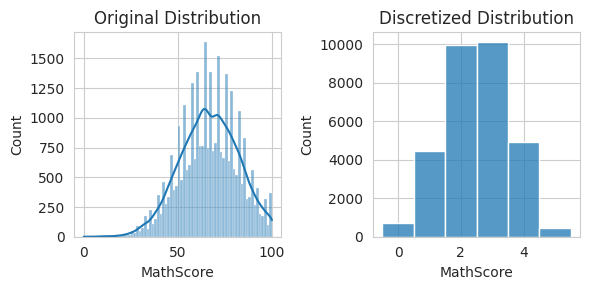

In [163]:
plt.figure(figsize=(6, 3))

# Original distribution
plt.subplot(1, 2, 1)
sns.histplot(df['MathScore'], bins='auto', kde=True)
plt.title('Original Distribution')

# Discretized distribution
plt.subplot(1, 2, 2)
sns.histplot(df_transformed['MathScore'], bins='auto', kde=False)
plt.title('Discretized Distribution')

plt.tight_layout()
plt.show()

### Start model tests

In [164]:
math_train_features, math_test_features, math_train_scores, math_test_scores = train_test_split(
    df_transformed.drop(['MathScore'], axis=1),
    df_transformed['MathScore'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", math_train_features.shape, math_train_scores.shape, "\n* Test set:",  math_test_features.shape, math_test_scores.shape)

* Train set: (24512, 5) (24512,) 
* Test set: (6129, 5) (6129,)


In [160]:
model_search = HyperparameterOptimizationSearch(models=models_algorithm_list, parameters=parameters_list)
model_search.fit(math_train_features, math_train_scores, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)



Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [161]:
efd_2_model_grid_search_summary, efd_2_model_grid_search_pipelines = model_search.score_summary(sort_by='mean_score')
efd_2_model_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
0,XGBClassifier,0.0,0.0,0.0,0.0
1,DecisionTreeClassifier,0.0,0.0,0.0,0.0
2,RandomForestClassifier,0.0,0.0,0.0,0.0
3,GradientBoostingClassifier,0.0,0.0,0.0,0.0
4,ExtraTreesClassifier,0.0,0.0,0.0,0.0
5,AdaBoostClassifier,0.0,0.0,0.0,0.0
